In [1]:
import numpy as np

import keras
import keras.backend as K
import theano.tensor as T
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.fugure_format = 'retina'

%load_ext autoreload

Using TensorFlow backend.


In [2]:
print(K.image_data_format())

channels_last


In [3]:
IMAGE_PATCH_SHAPE = (64, 64, 1)

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, Flatten
from keras.activations import relu
    
# siam-l2 from "Learning to Compare Image Patches via Convolutional Neural Networks"
descriptor = Sequential()
descriptor.add(Conv2D(96, kernel_size=7, strides=3, activation=relu, input_shape=IMAGE_PATCH_SHAPE))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Conv2D(192, kernel_size=5, strides=1, activation=relu))
descriptor.add(MaxPooling2D(pool_size=2, strides=2))
descriptor.add(Dropout(0.2))
descriptor.add(Conv2D(256, kernel_size=3, strides=1, activation=relu))
descriptor.add(Flatten())
descriptor.add(Lambda(lambda x : K.l2_normalize(x, axis=1))) # TODO check normalization

print(descriptor.input_shape, descriptor.output_shape)

(None, 64, 64, 1) (None, 256)


In [6]:
def euclidean_distance(vects):
    assert len(vects) == 2
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
from keras.models import Model
from keras.layers import Input

input_a = Input(shape=IMAGE_PATCH_SHAPE)
input_b = Input(shape=IMAGE_PATCH_SHAPE)

descriptor_a = descriptor(input_a)
descriptor_b = descriptor(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([descriptor_a, descriptor_b])
model = Model(inputs=[input_a, input_b], outputs=distance)

print(model.input_shape, model.output_shape)

[(None, 64, 64, 1), (None, 64, 64, 1)] (None, 1)


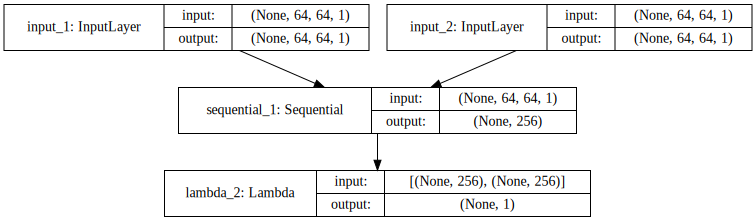

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [19]:
from keras.optimizers import SGD, Adam
from keras.losses import hinge

#model.compile(loss=hinge_onehot, optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True)) #TODO try Average SGD
model.compile(loss=hinge, optimizer=Adam())

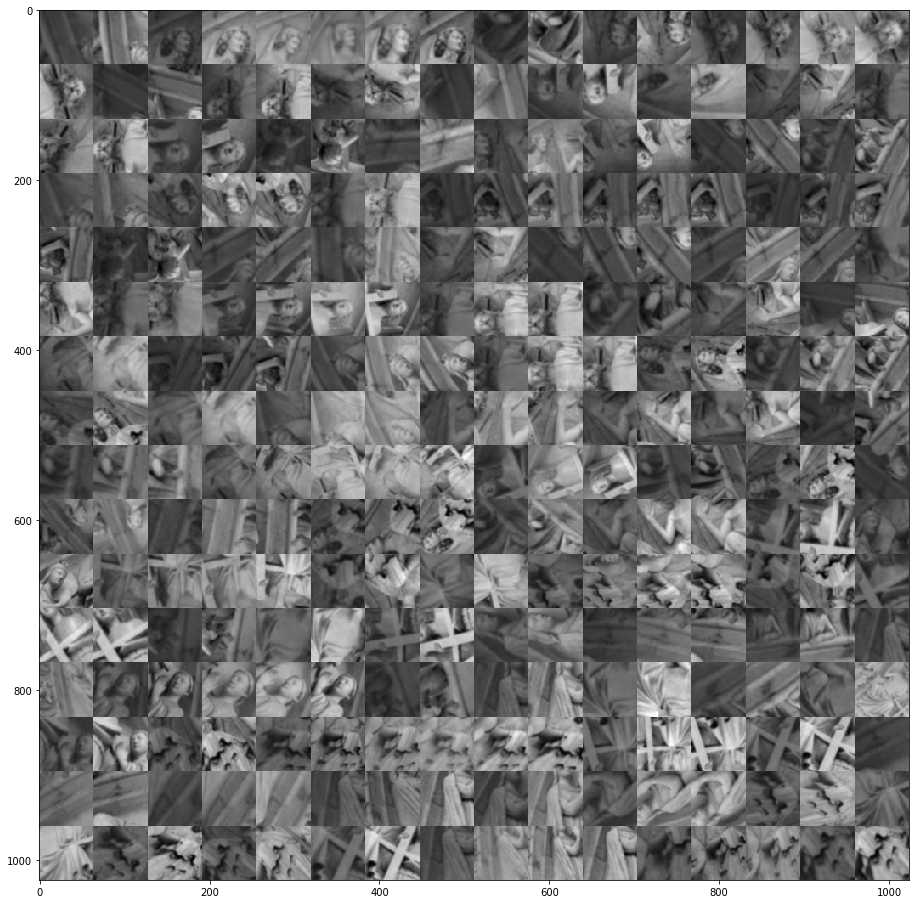

In [10]:
from utils import read_bitmap, read_patch, cut_patch_from_bitmap

DATA_ROOT = '../data'

bmp = read_bitmap(f'{DATA_ROOT}/notredame', 0)
plt.figure(figsize=(16, 16))
plt.imshow(bmp, shape=(16, 16), cmap='gray');

In [11]:
cut_patch_from_bitmap(bmp, 12).shape

(64, 64)

In [12]:
info_file = pd.read_csv(f'{DATA_ROOT}/notredame/info.txt', delimiter=' ', names=['patch_id', 'unused'])
info_file[10:16]

,patch_id,unused
10,3,0
11,3,0
12,4,0
13,4,0
14,4,0
15,4,0


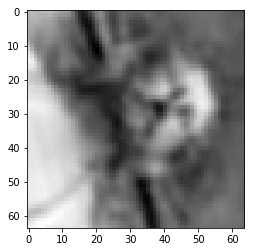

In [13]:
plt.imshow(read_patch(f'{DATA_ROOT}/notredame', 12), cmap='gray');

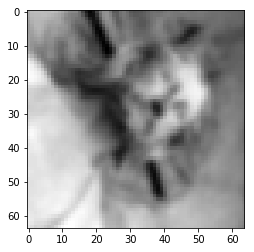

In [14]:
plt.imshow(read_patch(f'{DATA_ROOT}/notredame', 13), cmap='gray');

In [15]:
match_file = pd.read_csv(f'{DATA_ROOT}/notredame/m50_1000_1000_0.txt', delimiter=' ', 
    names=['patchID1', '3DpointID1', 'unused1', 'patchID2','3DpointID2', 'unused2', 'unused3'])
match_file.head()

,patchID1,3DpointID1,unused1,patchID2,3DpointID2,unused2,unused3
0,303022,92162,0,303023,92162,0,0
1,72213,21665,0,102184,30818,0,0
2,117329,35239,0,152168,46336,0,0
3,53674,16452,0,383549,120138,0,0
4,94442,28695,0,378765,118277,0,0


In [16]:
!ls {DATA_ROOT}/notredame/m50_*.txt

../data/notredame/m50_100000_100000_0.txt
../data/notredame/m50_10000_10000_0.txt
../data/notredame/m50_1000_1000_0.txt
../data/notredame/m50_200000_200000_0.txt
../data/notredame/m50_20000_20000_0.txt
../data/notredame/m50_2000_2000_0.txt
../data/notredame/m50_500000_500000_0.txt
../data/notredame/m50_50000_50000_0.txt
../data/notredame/m50_5000_5000_0.txt


In [17]:
%autoreload

In [20]:
from utils import get_generator
from keras.callbacks import TensorBoard

train_generator = get_generator(f'{DATA_ROOT}/notredame', 2000, batch_size=128)
validation_generator = get_generator(f'{DATA_ROOT}/notredame', 1000, batch_size=128)

tensorboard = TensorBoard()

history = model.fit_generator(train_generator, steps_per_epoch=2000 // 128, epochs=5, 
    validation_data=validation_generator, validation_steps=1000 // 128, callbacks=[tensorboard])

Epoch 1/5
15/15 [==============================] - 35s 2s/step - loss: 1.0000 - val_loss: 1.0009
Epoch 2/5
15/15 [==============================] - 34s 2s/step - loss: 1.0000 - val_loss: 1.0010
Epoch 3/5
15/15 [==============================] - 38s 3s/step - loss: 1.0005 - val_loss: 1.0010
Epoch 4/5
15/15 [==============================] - 43s 3s/step - loss: 0.9999 - val_loss: 1.0009
Epoch 5/5
15/15 [==============================] - 36s 2s/step - loss: 1.0002 - val_loss: 1.0010


In [18]:
inputs, true = next(get_generator(f'{DATA_ROOT}/notredame', 1000, batch_size=1000))
pred = model.predict(inputs)

In [33]:
pred

array([ 0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.01541195,  0.01541195,  0.01541195,
        0.01541195,  0.01541195,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00770235,
        0.00770235,  0.00770235,  0.00770235,  0.00770235,  0.00922222,
        0.00922222,  0.00922222,  0.00922222,  0.00922222,  0.00

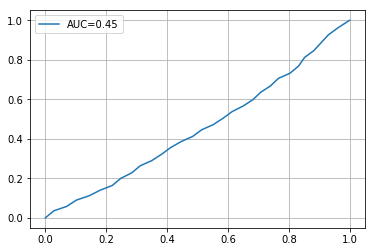

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)
plt.grid()
plt.plot(fpr, tpr, label=f'AUC={roc_auc:0.2f}')
plt.legend()
plt.show()

In [20]:
model.layers

In [21]:
descr = model.layers[2]
embeddings = descr.predict(inputs[0])

In [24]:
from numpy.linalg import norm

[norm(e) for e in embeddings]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99999988,
 1.0,
 0.99999988,
 1.0,
 0.99999994,
 1.0000001,
 1.0,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0000001,
 1.0,
 0.99999994,
 1.0,
 0.99999988,
 0.99999988,
 0.99999994,
 0.99999994,
 1.0000001,
 0.99999994,
 0.99999994,
 0.99999994,
 0.99999994,
 1.0,
 0.99999994,
 1.0,
 0.99999994,
 0.99999994,
 1.0000001,
 0.99999994,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000001,
 1.0,
 1.0000001,
 0.99999994,
 1.0,
 0.99999994,
 1.0,
 0.99999994,
 0.99999988,
 1.0,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 0.99999988,
 0.99999988,
 0.99999994,
 1.0,
 0.99999988,
 1.0,
 1.0,
 0.99999994,
 0.99999994,
 0.99999988,
 0.99999994,
 0.99999994,
 1.0,
 0.99999988,
 0.99999994,
 0.99999988,
 0.99999994,
 0.99999994,
 1.0,
 0.99999994,
 0.99999988,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 1.0,
 0.99999988,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 0.99999988,
 1.0,
 0.99999994,
 0.99999994,
 1.0000001,
 1.0,
 1.0,
 0.99999994,
 1.0,
 1.0,
 0.99999994,
 0.